In [24]:
import numpy as np
from pathlib import Path
from os import PathLike

MIB = 1 << 20

def read_flash_file(path: PathLike) -> np.array:
    with Path(path).open('rb') as f:
        return np.frombuffer(f.read(), dtype=np.uint8)

flashes = Path('./flash-dumps')

new1full = read_flash_file(flashes / 'new1.bin')[:2 * MIB]
new2full = read_flash_file(flashes / 'new2.bin')[:2 * MIB]
live_fw = read_flash_file(flashes / 'raw-flash.bin')[:2 * MIB]

In [25]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import math

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["figure.facecolor"] = "w"
plt.show()

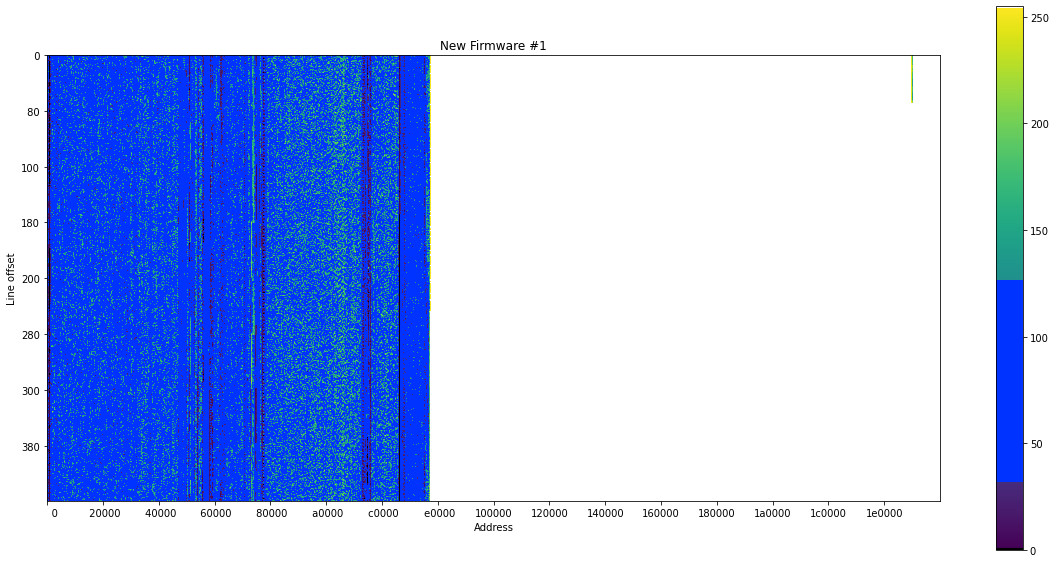

In [125]:
def mk_byteclass_cmap():
    """
    Inspired by the https://binvis.io/ byteclass colormap.
    
    - ZERO: 0
    - LOW: [1, 31]
    - ASCII: [32, 126]
    - HIGH: [127, 254]
    - FF: 255
    """
    base = cm.get_cmap('viridis', 256)
    
    newcolors = base(np.linspace(0, 1, 256))
    newcolors[0] = [0, 0, 0, 1]
    newcolors[32:127] = [0, .2, 1, 1]
    newcolors[255] = [1, 1, 1, 1]
    return ListedColormap(newcolors)

byteclass_cmap = mk_byteclass_cmap()

def plot_bin(b: np.array, *, ax=None, offset_tick_interval=128, line_tick_interval=128, binline_length=1024, **imshow_kwargs):
    extended_length = math.ceil(len(b) / binline_length) * binline_length
    extended = np.pad(b, (0, extended_length - len(b)), constant_values=0)
    data = np.reshape(extended, (-1, binline_length)).T
    
    imshow_kwargs = {'cmap': byteclass_cmap, **imshow_kwargs}
    plt.imshow(data, **imshow_kwargs)
    plt.ylabel('Line offset')
    plt.xlabel('Address')
    
    def fmt_slice_index(x, p):
        x = int(x) * binline_length
        return f"{x:6x}"
    
    def fmt_slice_offset(x, p):
        x = int(x)
        return f"{x:3x}"

    axes = plt.gca()
    axes.get_xaxis().set_major_locator(ticker.MultipleLocator(line_tick_interval))
    axes.get_xaxis().set_major_formatter(ticker.FuncFormatter(fmt_slice_index))
    axes.get_yaxis().set_major_locator(ticker.MultipleLocator(offset_tick_interval))
    axes.get_yaxis().set_major_formatter(ticker.FuncFormatter(fmt_slice_offset))

plot_bin(new1full)
plt.title('New Firmware #1')
plt.colorbar()
plt.show()

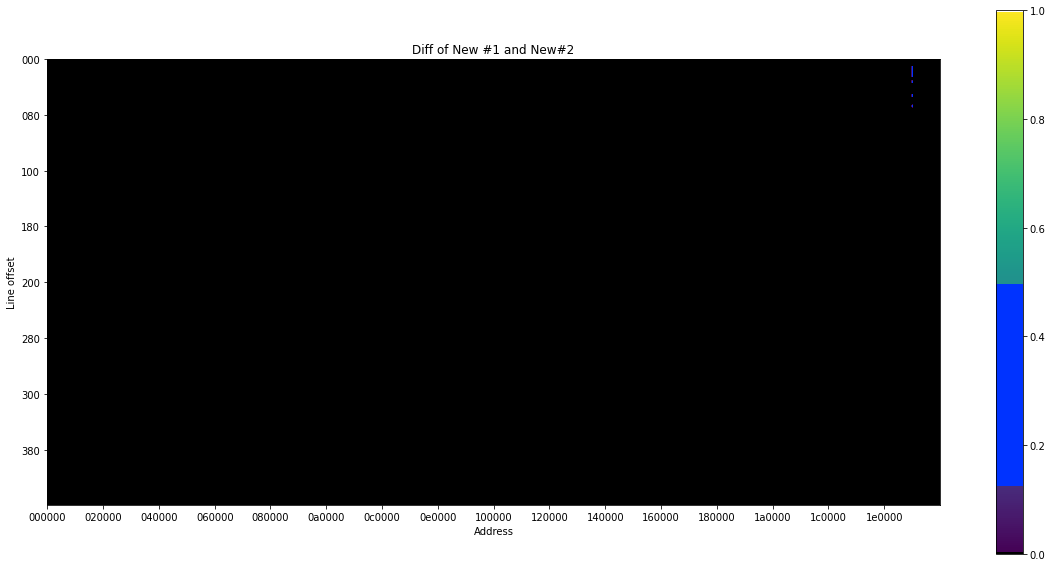

In [27]:
diff_mask = (new1full != new2full)

plot_bin(diff_mask, vmin=0, vmax=1)
plt.title('Diff of New #1 and New#2')
plt.colorbar()
plt.show()

In [28]:
unshared_data_new = [(hex(i), hex(a), hex(b)) for i, (a, b) in enumerate(zip(new1full, new2full)) if a != b]
unshared_data_new

[('0x1f0013', '0x46', '0x42'),
 ('0x1f0015', '0x7c', '0xe8'),
 ('0x1f0016', '0x63', '0xd8'),
 ('0x1f0017', '0x5', '0x7e'),
 ('0x1f0018', '0x4a', '0x62'),
 ('0x1f0019', '0xca', '0xef'),
 ('0x1f001a', '0x54', '0x41'),
 ('0x1f001b', '0xa7', '0x2'),
 ('0x1f001c', '0xe1', '0xff'),
 ('0x1f001d', '0x48', '0x85'),
 ('0x1f001e', '0x67', '0x63'),
 ('0x1f001f', '0x93', '0x84'),
 ('0x1f0020', '0x46', '0x8a'),
 ('0x1f0021', '0xa9', '0xce'),
 ('0x1f0022', '0x19', '0xb6'),
 ('0x1f0023', '0x1c', '0x92'),
 ('0x1f0024', '0x75', '0xe6'),
 ('0x1f0025', '0xdf', '0xdd'),
 ('0x1f0026', '0x8f', '0x2a'),
 ('0x1f0027', '0x5', '0xb9'),
 ('0x1f0028', '0xa3', '0x25'),
 ('0x1f0029', '0x34', '0x60'),
 ('0x1f002a', '0x4b', '0x18'),
 ('0x1f0034', '0x38', '0x39'),
 ('0x1f0035', '0x33', '0x43'),
 ('0x1f0036', '0x46', '0x37'),
 ('0x1f0037', '0x45', '0x34'),
 ('0x1f0054', '0x38', '0x42'),
 ('0x1f0055', '0x41', '0x38'),
 ('0x1f0056', '0x46', '0x42'),
 ('0x1f0057', '0x44', '0x42'),
 ('0x1f006c', '0xc1', '0xa3'),
 ('0x1f006d

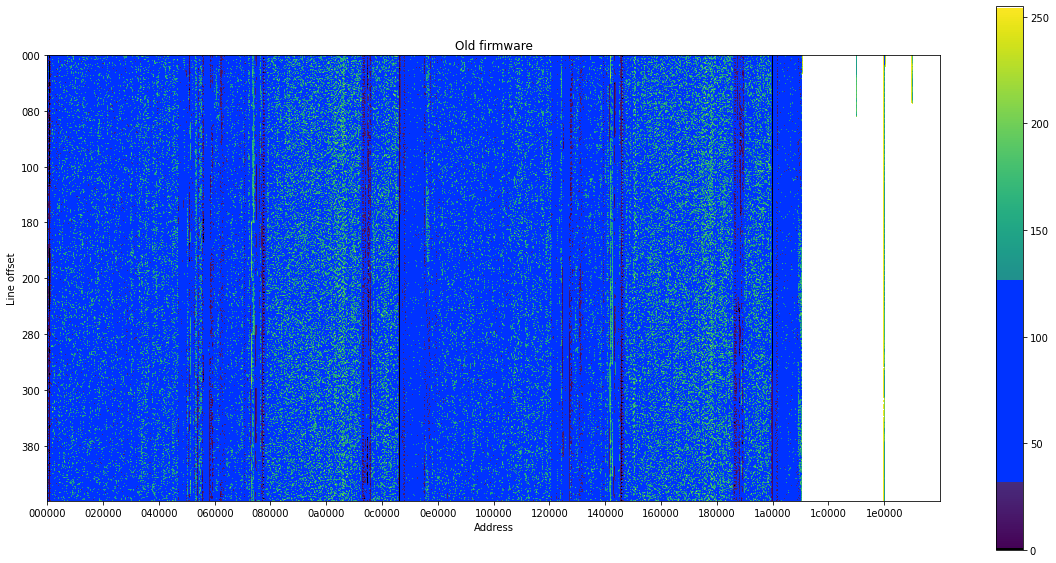

In [29]:
plot_bin(live_fw)
plt.title('Old firmware')
plt.colorbar()
plt.show()

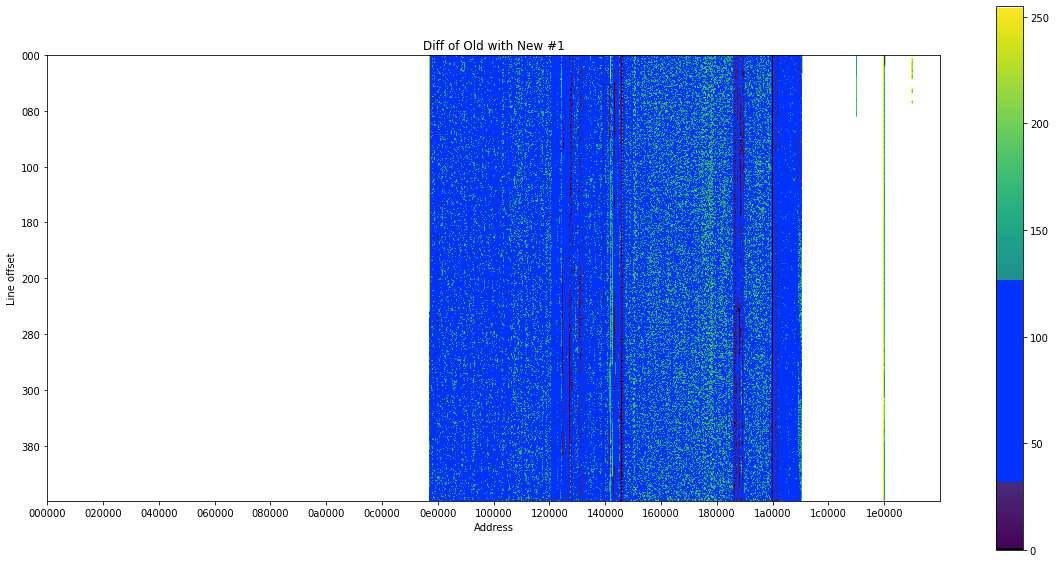

In [30]:
live_fw_diff = live_fw.astype('int16')
live_fw_diff[new1full == live_fw] = 0xff  # clear similar bytes

plot_bin(live_fw_diff)
plt.title('Diff of Old with New #1')
plt.colorbar()
plt.show()

In [31]:
for ab_border, (n, o) in enumerate(zip(new1full, live_fw)):
    if n != o:
        print(ab_border, hex(ab_border))
        break

898636 0xdb64c


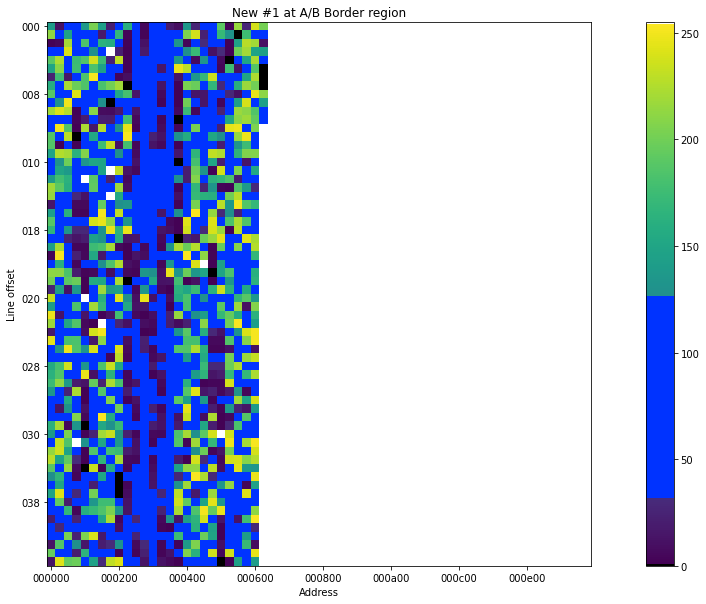

In [32]:
plot_bin(new1full[0xdb000:0xdc000], offset_tick_interval=8, line_tick_interval=8, binline_length=64)
plt.title('New #1 at A/B Border region')
plt.colorbar()
plt.show()

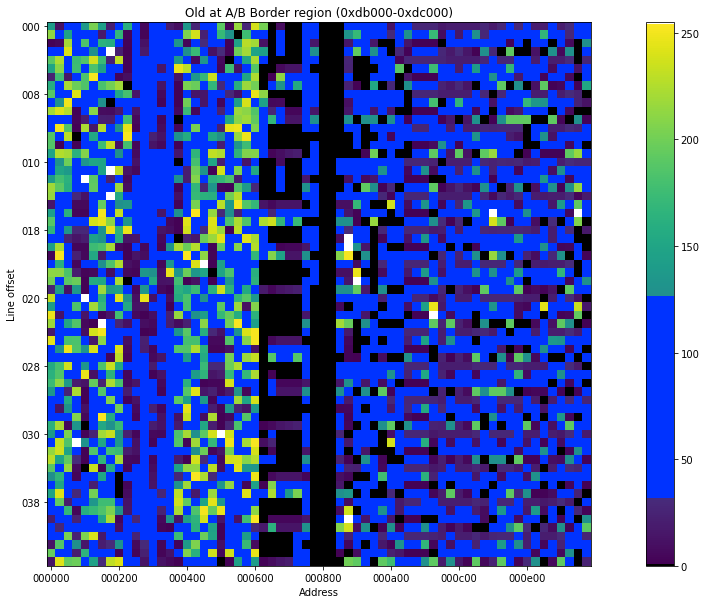

In [33]:
plot_bin(live_fw[0xdb000: 0xdc000], offset_tick_interval=8, line_tick_interval=8, binline_length=64)
plt.title('Old at A/B Border region (0xdb000-0xdc000)')
plt.colorbar()
plt.show()

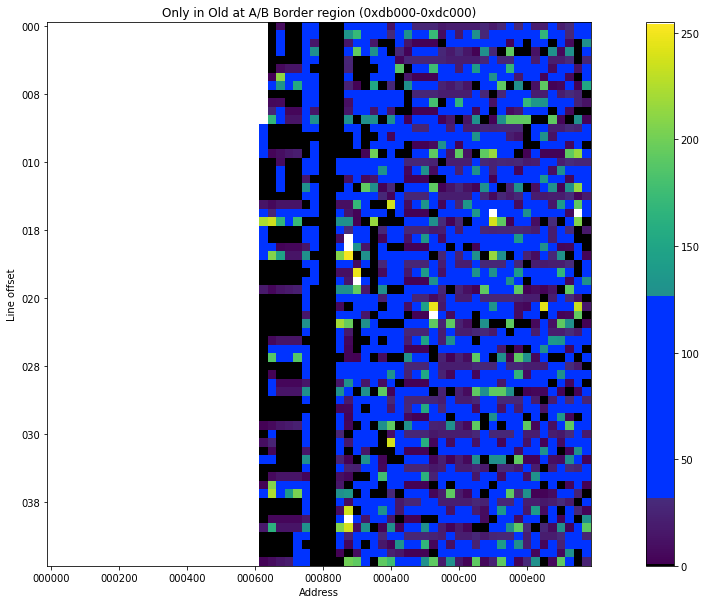

In [34]:
plot_bin(live_fw_diff[0xdb000: 0xdc000], offset_tick_interval=8, line_tick_interval=8, binline_length=64)
plt.title('Only in Old at A/B Border region (0xdb000-0xdc000)')
plt.colorbar()
plt.show()

In [35]:
bytes(live_fw[ab_border:ab_border + 100])

b'BUND\x00\x00\x00\x00\x00\rU\xe0owl \x00\x00\x00\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\t\x00J\x00\x00\x010\x00\x00\x00\x11\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x01D\x00\x05\x1b\xa8\x00\x00\x00\x03\x00\x00\x00\x00\x00\x05\x1c\xec\x00\x00K\xd0\x00\x00\x00\x04\x00\x00\x00\x00\x00\x05h\xbc\x00\x01h$\x00\x00\x00\x06'

In [36]:
bund_magic = b'BUND\0\0\0\0\0\r'

bund1_offset = bytes(new1full).find(bund_magic)  # BUND occurs in fresh
bund1_offset, hex(bund1_offset)

(7168, '0x1c00')

In [37]:
bund_magic in bytes(new1full)[bund1_offset + 1:]  # no other occurrences past that

False

In [38]:
bytes(new1full)[bund1_offset:bund1_offset + 100]

b'BUND\x00\x00\x00\x00\x00\r\x9aLowl \x00\x00\x00\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\t\x00$\x00\x00\x010\x00\x00\x00\x18\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x01H\x00\x05\xd7\xb0\x00\x00\x00\x03\x00\x00\x00\x00\x00\x05\xd8\xf8\x00\x00L\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x06$\xf8\x00\x01l\xf0\x00\x00\x00\x06'

In [39]:
for i in range(0x1c0000, 0, -1):
    if live_fw[i] != 255:
        end_of_b = i + 1
        break

end_of_b, hex(end_of_b)

(1772588, '0x1b0c2c')

891468 0xd9a4c


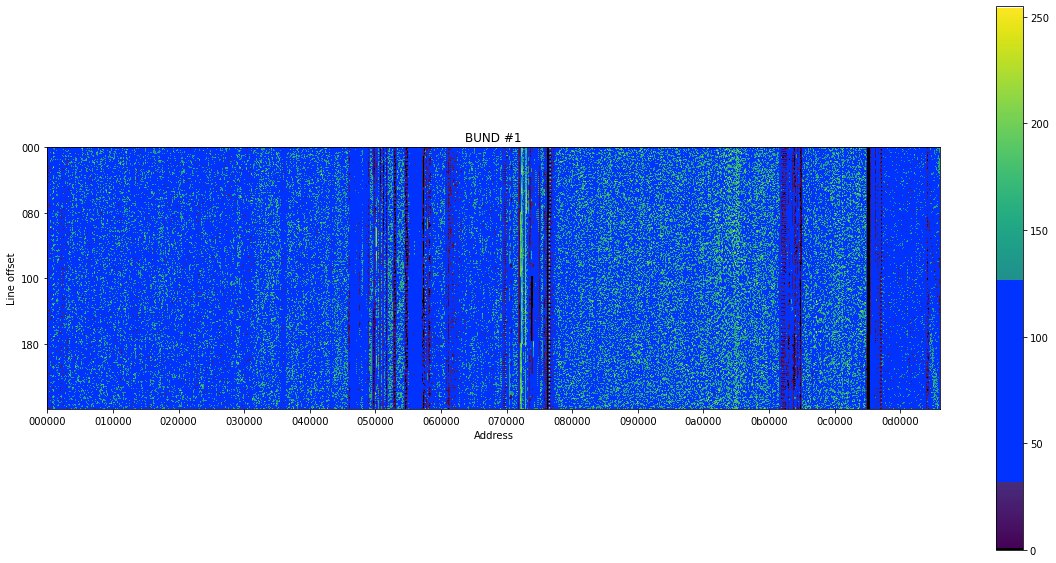

In [40]:
bund1 = live_fw[bund1_offset:ab_border]
print(len(bund1), hex(len(bund1)))

plot_bin(bund1, binline_length=512)
plt.title('BUND #1')
plt.colorbar()
plt.show()


873952 0xd55e0


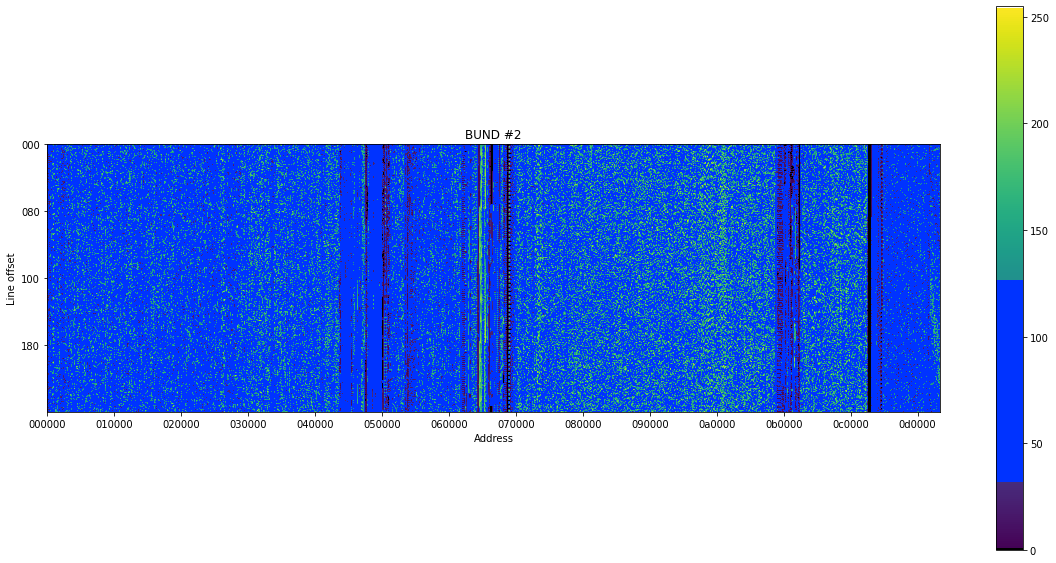

In [41]:
bund2 = live_fw[ab_border:end_of_b]
print(len(bund2), hex(len(bund2)))

plot_bin(bund2, binline_length=512)
plt.title('BUND #2')
plt.colorbar()
plt.show()

Total bytes in BUND1: 891468
Total bytes in BUND2: 873952
Different bytes: 868827
Same bytes: 22641
97.460% difference


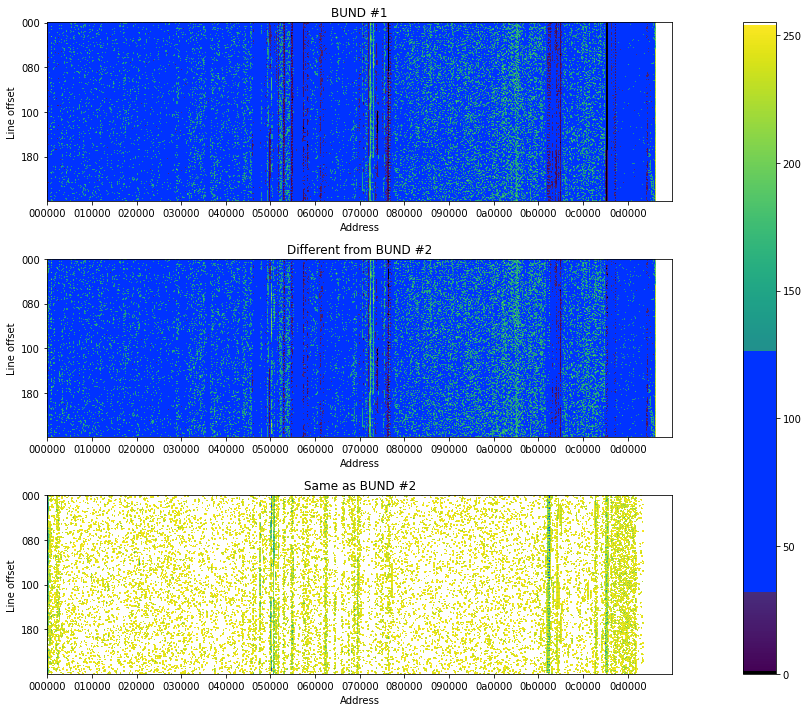

In [42]:
pad_to = 0xe0000

bund1_pad = np.pad(bund1, (0, pad_to - len(bund1)), constant_values=0xff)
bund2_pad = np.pad(bund2, (0, pad_to - len(bund2)), constant_values=0xff)

bund_same = bund1_pad.copy()
bund_same[bund1_pad != bund2_pad] = 0xff

bund_diff = bund1_pad.copy()
bund_diff[bund1_pad == bund2_pad] = 0xff

ndiff = len(bund1_pad[bund1_pad != bund2_pad])
print('Total bytes in BUND1:', len(bund1))
print('Total bytes in BUND2:', len(bund2))
print('Different bytes:', ndiff)
print('Same bytes:', len(bund1) - ndiff)
print(f'{ndiff * 100 / len(bund1):.03f}% difference')

_, axs = plt.subplots(3, 1)
(ax_bund1, ax_diff, ax_same) = axs

plt.sca(ax_bund1)
plot_bin(bund1_pad, binline_length=512)
plt.title('BUND #1')

plt.sca(ax_diff)
plot_bin(bund_diff, binline_length=512)
plt.title('Different from BUND #2')

plt.sca(ax_same)
plot_bin(bund_same, binline_length=512)
plt.title('Same as BUND #2')

plt.tight_layout()

plt.colorbar(ax=axs)

plt.show()

In [43]:
with Path('flash-dumps/bund1.bin').open('wb') as f:
    f.write(bytes(bund1))

with Path('flash-dumps/bund2.bin').open('wb') as f:
    f.write(bytes(bund2))

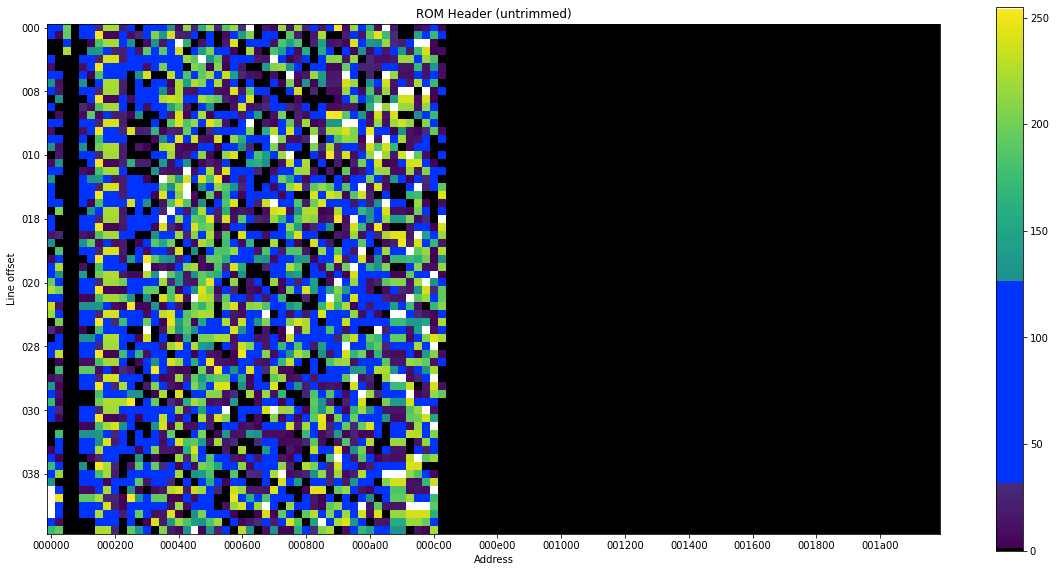

In [55]:
rom_header = live_fw[:bund1_offset]

plot_bin(rom_header, binline_length=64, offset_tick_interval=8, line_tick_interval=8)
plt.title('ROM Header (untrimmed)')
plt.colorbar()
plt.show()

3183 0xc6f


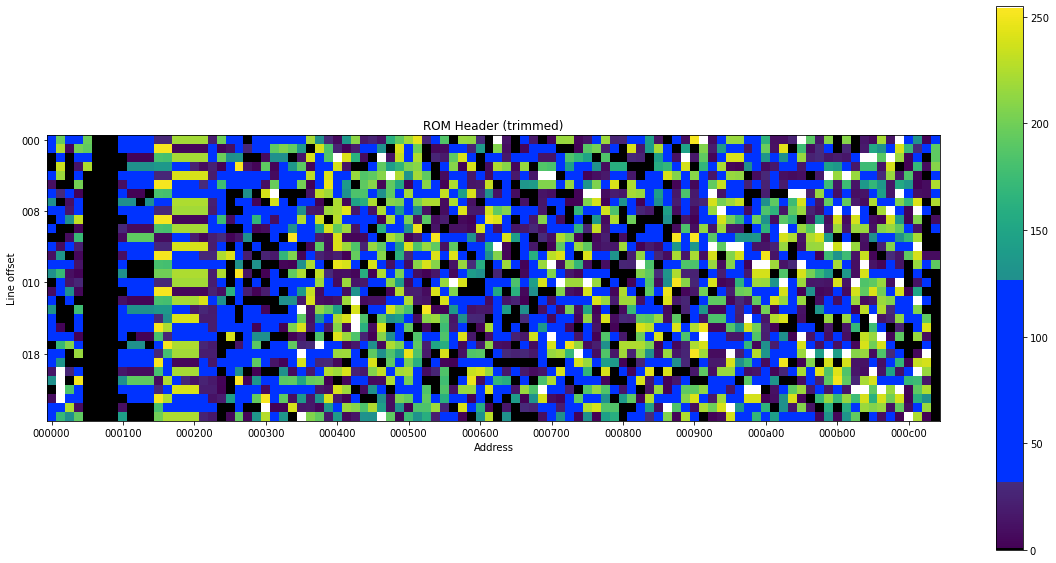

In [56]:
for i in range(len(rom_header) - 1, 0, -1):
    if rom_header[i] != 0:
        rom_header_len = i + 1
        break

rom_header_trim = rom_header[:math.ceil(rom_header_len / 4) * 4]
print(rom_header_len, hex(rom_header_len))

plot_bin(rom_header_trim, binline_length=32, offset_tick_interval=8, line_tick_interval=8)
plt.title('ROM Header (trimmed)')
plt.colorbar()
plt.show()

In [115]:
from hexdump import hexdump

hexdump(bytes(rom_header_trim))

00000000: 20 4A 00 00 24 0A 3F 80  20 00 21 00 22 0A 3F 80   J..$.?. .!.".?.
00000010: 00 08 40 84 23 4A 30 00  20 22 0F 80 00 08 40 20  ..@.#J0. "....@ 
00000020: C5 E1 75 EB D9 00 1E 00  70 60 00 00 08 84 26 AB  ..u.....p`....&.
00000030: 70 44 00 00 00 02 26 AB  70 84 FF FF FF FF 26 AB  pD....&.p.....&.
00000040: 70 04 00 00 00 00 24 0A  0F 80 00 08 41 00 25 0A  p.....$.....A.%.
00000050: 0F 80 20 00 00 00 70 CF  00 00 1B 00 B8 22 E0 80  .. ...p......"..
00000060: 24 CA 70 0D 23 CA 01 4D  20 E8 01 AD 14 04 0C 02  $.p.#..M .......
00000070: 1B 04 00 B0 20 22 01 40  D8 00 75 FB 20 21 07 C0  .... ".@..u. !..
00000080: C5 C1 78 E0 00 00 00 00  00 00 00 00 00 00 00 00  ..x.............
00000090: 00 00 00 00 00 00 00 00  00 00 00 00 00 00 00 00  ................
000000A0: 00 00 00 00 00 00 00 00  00 00 00 00 00 00 00 00  ................
000000B0: 00 00 00 00 00 00 00 00  00 00 00 00 00 00 00 00  ................
000000C0: 00 00 00 00 00 00 00 00  00 00 00 00 00 00 00 00  ................

In [90]:
import struct

def find_word(x: int, b: bytes):
    le = b.find(struct.pack('<I', x))
    be = b.find(struct.pack('>I', x))
    return le, be

rh = bytes(rom_header_trim)

searches = [
    len(bund1),
    len(bund2),
    bund1_offset,
    ab_border,
    ab_border - bund1_offset,
]

for i, x in enumerate(searches):
    le, be = find_word(x, rh)
    out = [f'{i}. {x:x}:']
    if le >= 0:
        out.append(f'LE {le}d {le:x}h')
    if be >= 0:
        out.append(f'BE {be}d {be:x}h')
    
    print('\t'.join(out))
        
_, bund1_offset_loc = find_word(bund1_offset, rh)

0. d9a4c:
1. d55e0:
2. 1c00:	BE 2668d a6ch
3. db64c:
4. d9a4c:


00000000: 0D 42 FF EF DA 20 C2 04  70 C9 BA 04 E2 20 0D 36  .B... ..p.... .6
00000010: FF EF 71 A9 A5 C5 85 07  1D 18 15 80 B8 82 A5 07  ..q.............
00000020: 0E FA FF EF D8 46 77 C9  0F 17 15 80 85 07 20 4F  .....Fw....... O
00000030: 00 01 A5 27 0A 0B 20 10  20 45 00 C0 A5 07 25 40  ...'.. . E....%@
00000040: 18 0E DA 00 85 24 F0 03  E2 01 6A 14 20 70 03 83  .....$....j. p..
00000050: 0B 09 00 90 0A F5 80 44  0A 13 00 44 0E BE FF EF  .......D...D....
00000060: D8 41 0E BA FF EF D8 33  F0 00 80 42 62 FA 1B 00  .A.....3...Bb...
00000070: 20 80 80 23 18 00 20 40  07 7D FF AF C0 A8 78 E0   ..#.. @.}....x.
00000080: 00 00 1C 00 42 55 4E 44  00 00 01 50 20 00 21 00  ....BUND...P .!.
00000090: C0 F1 0F 32 FF AF D8 0F  0A 5E FF EF D9 00 D8 0E  ...2.....^......
000000A0: 0A 56 FF EF D9 01 D8 0C  0A 4E FF EF D9 01 DE 09  .V.......N......
000000B0: D9 03 D0 3B BE 08 18 24  00 60 16 5C 18 0D BD E0  ...;...$.`.\....
000000C0: D8 57 20 CA 0F 81 00 00  00 43 0E 52 FF CF 25 4F  .W ......C.R..%O

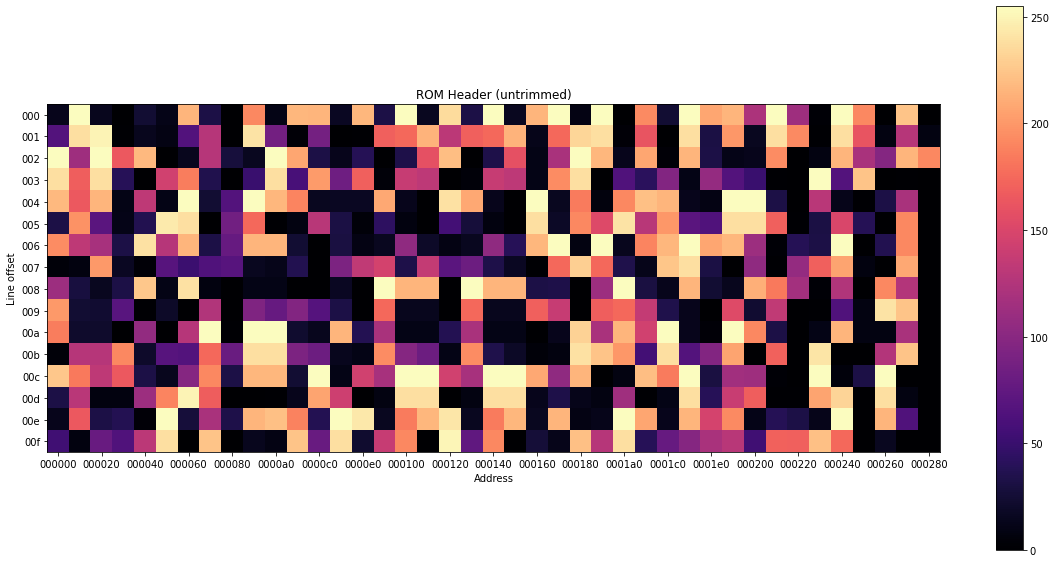

In [109]:
region = rom_header_trim[bund1_offset_loc - 128:]

hexdump(region)
plot_bin(region, binline_length=16, offset_tick_interval=1, line_tick_interval=2, cmap='magma')
plt.title('ROM Header (untrimmed)')
plt.colorbar()
plt.show()

In [124]:
Lstruct1, Lstruct2 = region[0xe0:0x120], region[0x120:0x160]
hexdump(Lstruct1)
print()
hexdump(Lstruct2)

00000000: D9 01 26 AA 10 04 09 86  00 00 25 0A 90 00 F4 16  ..&.......%.....
00000010: 20 AA 00 04 D1 2B 0F 92  FF AF 78 C2 77 08 0F 8A   ....+....x.w...
00000020: FF AF 21 8A 0D 07 68 21  D8 0E 0A 62 FF EF B9 C0  ..!...h!...b....
00000030: 0F D7 9F 84 00 00 13 88  D8 0E 0A 52 FF EF D9 00  ...........R....

00000000: ED 83 DD 00 F0 38 09 46  00 00 25 0A 90 00 F3 FB  .....8.F..%.....
00000010: 20 AA 00 04 D1 1B 0F 52  FF AF 78 C2 77 08 0F 4A   ......R..x.w..J
00000020: FF AF 21 8A 0D 07 68 21  D8 0E 0A 22 FF EF B9 C0  ..!...h!..."....
00000030: 0F D7 9F 84 00 00 27 10  D8 0E 0A 12 FF EF D9 00  ......'.........


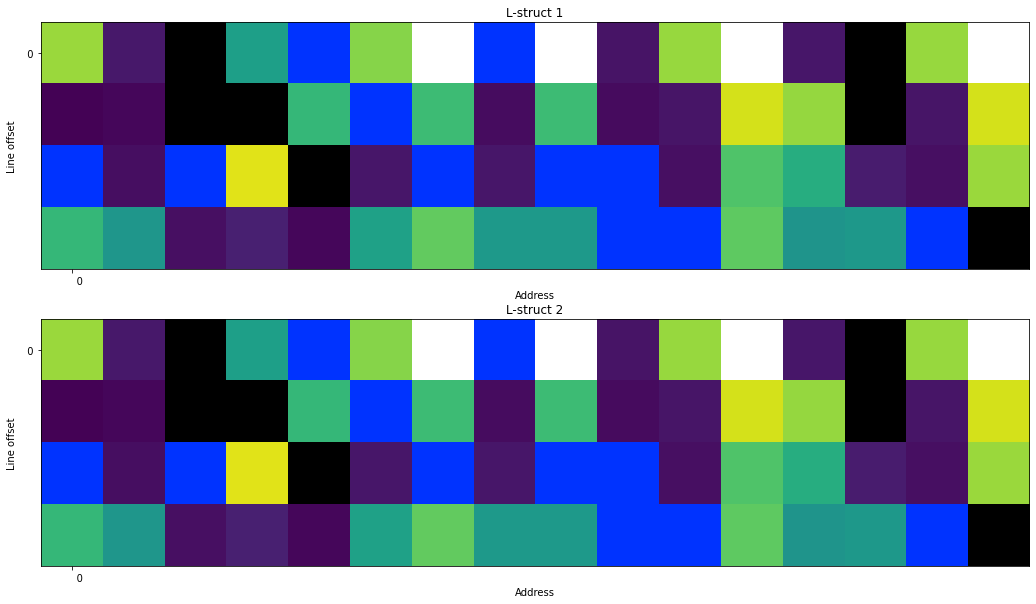

In [128]:
_, axs = plt.subplots(2, 1)
(ax_l1, ax_l2) = axs

plt.sca(ax_l1)
plot_bin(Lstruct1, binline_length=4)
plt.title('L-struct 1')

plt.sca(ax_l2)
plot_bin(Lstruct1, binline_length=4)
plt.title('L-struct 2')

plt.show()